In [1]:
import math
import seaborn as sns
import torch, torch.nn as nn
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import partial

# Załadowanie bazy

In [3]:
data = pd.read_csv('steam.csv')
data.head()

appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat enabled  Action   
3  Multi-player;Online Multi-Player;Local Multi-P...  Action   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   

                  steamspy_tags  achievements  positive_ratings  \
0        Action;FPS;Multiplayer             0            124534   
1        Action;FPS;Multiplayer             0              3318   
2  FPS;World War II;Multiplayer             0              3416   
3        Action;FPS;Multiplayer             0              1273   
4             FPS;Action;Sci-fi             0              5250   

   negative_ratings  average_playtime  median_playtime             owners  \
0              3339             17612              317  10000000-20000000   
1               633               277               62   5000000-10000000   
2               398               187               34   5000000-10000000   
3               267               258              184   5000000-10000000   
4               288               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

#  Przygotowanie bazy

In [4]:
data.shape

(27075, 18)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [6]:
data.dtypes

appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

In [7]:
data.developer = data.developer.str.lower() 
data.genres = data.genres.str.lower()
data.categories = data.categories.str.lower()
data.name = data.name.str.lower()
data.publisher = data.publisher.str.lower()
data.steamspy_tags = data.steamspy_tags.str.lower()

## Owners

In [8]:
data.owners.sort_values().unique()

array(['0-20000', '100000-200000', '1000000-2000000', '10000000-20000000',
       '100000000-200000000', '20000-50000', '200000-500000',
       '2000000-5000000', '20000000-50000000', '50000-100000',
       '500000-1000000', '5000000-10000000', '50000000-100000000'],
      dtype=object)

In [9]:
print('wartość procentowa gier z liczbą posiadaczy mniejszą niż 20000 : {}%'.format(round(np.sum(data.owners.isin(['0-20000']))*100/len(data),2)))

wartość procentowa gier z liczbą posiadaczy mniejszą niż 20000 : 68.68%


#### Usunięcie zbędnych danych (gier które nie dotarły do większej żeszy graczy)

In [10]:
cleaner_data = data.loc[data['owners'] != '0-20000']
cleaner_data.owners.sort_values().unique()

array(['100000-200000', '1000000-2000000', '10000000-20000000',
       '100000000-200000000', '20000-50000', '200000-500000',
       '2000000-5000000', '20000000-50000000', '50000-100000',
       '500000-1000000', '5000000-10000000', '50000000-100000000'],
      dtype=object)

## Czyszczenie kolumn

## Categories, genres, steamspy_tags

#### Przekonwertowanie wartości z kolumn: platforms, categories, genres oraz steamspy_tags na listy

In [11]:
listed_data = cleaner_data

pd.options.mode.chained_assignment = None  # default='warn'
listed_data.categories = listed_data.categories.str.split(';')
listed_data.platforms = listed_data.platforms.str.split(';')
listed_data.genres = listed_data.genres.str.split(';')
listed_data.steamspy_tags = listed_data.steamspy_tags.str.split(';')
listed_data.developer = listed_data.developer.str.split(';')
listed_data.publisher = listed_data.publisher.str.split(';')

listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher              platforms  required_age  \
0   [valve]  [windows, mac, linux]             0   
1   [valve]  [windows, mac, linux]             0   
2   [valve]  [windows, mac, linux]             0   
3   [valve]  [windows, mac, linux]             0   
4   [valve]  [windows, mac, linux]             0   

                                          categories    genres  \
0  [multi-player, online multi-player, local mult...  [action]   
1  [multi-player, online multi-player, local mult...  [action]   
2           [multi-player, valve anti-cheat enabled]  [action]   
3  [multi-player, online multi-player, local mult...  [action]   
4  [single-player, multi-player, valve anti-cheat...  [action]   

                      steamspy_tags  achievements  positive_ratings  \
0        [action, fps, multiplayer]             0            124534   
1        [action, fps, multiplayer]             0              3318   
2  [fps, world war ii, multiplayer]             0              3416   
3        [action, fps, multiplayer]             0              1273   
4             [fps, action, sci-fi]             0              5250   

   negative_ratings  average_playtime  median_playtime             owners  \
0              3339             17612              317  10000000-20000000   
1               633               277               62   5000000-10000000   
2               398               187               34   5000000-10000000   
3               267               258              184   5000000-10000000   
4               288               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

In [12]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [13]:
to_1D(listed_data['categories']).value_counts()

single-player                 7856
steam achievements            5028
steam trading cards           4544
steam cloud                   3075
full controller support       2072
multi-player                  1982
partial controller support    1512
steam leaderboards            1341
online multi-player           1015
co-op                          867
stats                          702
shared/split screen            689
cross-platform multiplayer     568
online co-op                   513
steam workshop                 508
in-app purchases               504
includes level editor          478
local multi-player             343
mmo                            299
captions available             287
local co-op                    246
vr support                     110
valve anti-cheat enabled        94
commentary available            81
steamvr collectibles            28
includes source sdk             26
steam turn notifications        25
mods                             2
mods (require hl2)  

In [14]:
listed_data = listed_data.drop(columns=['genres','steamspy_tags'])
listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher              platforms  required_age  \
0   [valve]  [windows, mac, linux]             0   
1   [valve]  [windows, mac, linux]             0   
2   [valve]  [windows, mac, linux]             0   
3   [valve]  [windows, mac, linux]             0   
4   [valve]  [windows, mac, linux]             0   

                                          categories  achievements  \
0  [multi-player, online multi-player, local mult...             0   
1  [multi-player, online multi-player, local mult...             0   
2           [multi-player, valve anti-cheat enabled]             0   
3  [multi-player, online multi-player, local mult...             0   
4  [single-player, multi-player, valve anti-cheat...             0   

   positive_ratings  negative_ratings  average_playtime  median_playtime  \
0            124534              3339             17612              317   
1              3318               633               277               62   
2              3416               398               187               34   
3              1273               267               258              184   
4              5250               288               624              415   

              owners  price  
0  10000000-20000000   7.19  
1   5000000-10000000   3.99  
2   5000000-10000000   3.99  
3   5000000-10000000   3.99  
4   5000000-10000000   3.99

## Platforms
#### Sprawdzenie wyników dla trzech platform PC

In [15]:
test_data2 = listed_data
test_data2 = test_data2.explode('platforms').reset_index(drop=True)

test_data2.platforms.unique()
test_data2.shape
item_counts = test_data2["platforms"].value_counts()
item_counts.head

<bound method NDFrame.head of windows    8478
mac        3259
linux      2247
Name: platforms, dtype: int64>

In [16]:
test_data2.head()

appid                   name release_date  english developer publisher  \
0     10         counter-strike   2000-11-01        1   [valve]   [valve]   
1     10         counter-strike   2000-11-01        1   [valve]   [valve]   
2     10         counter-strike   2000-11-01        1   [valve]   [valve]   
3     20  team fortress classic   1999-04-01        1   [valve]   [valve]   
4     20  team fortress classic   1999-04-01        1   [valve]   [valve]   

  platforms  required_age                                         categories  \
0   windows             0  [multi-player, online multi-player, local mult...   
1       mac             0  [multi-player, online multi-player, local mult...   
2     linux             0  [multi-player, online multi-player, local mult...   
3   windows             0  [multi-player, online multi-player, local mult...   
4       mac             0  [multi-player, online multi-player, local mult...   

   achievements  positive_ratings  negative_ratings  average_playtime  \
0             0            124534              3339             17612   
1             0            124534              3339             17612   
2             0            124534              3339             17612   
3             0              3318               633               277   
4             0              3318               633               277   

   median_playtime             owners  price  
0              317  10000000-20000000   7.19  
1              317  10000000-20000000   7.19  
2              317  10000000-20000000   7.19  
3               62   5000000-10000000   3.99  
4               62   5000000-10000000   3.99

In [17]:
list_platforms = to_1D(listed_data['platforms']).value_counts()
print(list_platforms)

windows    8478
mac        3259
linux      2247
dtype: int64


In [18]:
indexy = test_data2.appid
to_1D(listed_data['platforms']).value_counts()

windows    8478
mac        3259
linux      2247
dtype: int64

In [19]:
conditionw = test_data2['platforms'] != "windows"
conditionl = test_data2['platforms'] != "linux"
conditionm = test_data2['platforms'] != "mac"

windows_indices = indexy[conditionw]
windows_indices_list = windows_indices.tolist()
linux_indices = indexy[conditionl]
linux_indices_list = linux_indices.tolist()
mac_indices = indexy[conditionm]
mac_indices_list = mac_indices.tolist()

print(set(windows_indices_list) - set(mac_indices_list))
print(set(windows_indices_list) - set(linux_indices_list))

{214630}
set()


In [20]:
listed_data.loc[listed_data['appid'] == 214630]

appid                                   name release_date  english  \
1413  214630  call of duty: black ops - mac edition   2012-09-27        1   

     developer publisher platforms  required_age  \
1413   [aspyr]  [aspyr ]     [mac]            18   

                                             categories  achievements  \
1413  [single-player, multi-player, co-op, steam ach...            68   

      positive_ratings  negative_ratings  average_playtime  median_playtime  \
1413               168               105                 0                0   

            owners  price  
1413  50000-100000  15.49

In [21]:
listed_data = listed_data.loc[listed_data['appid'] != '214630']
listed_data.loc[listed_data['appid'] == '214630']

Empty DataFrame
Columns: [appid, name, release_date, english, developer, publisher, platforms, required_age, categories, achievements, positive_ratings, negative_ratings, average_playtime, median_playtime, owners, price]
Index: []

In [22]:
print('wartość procentowa gier dostępnych na system Windows : {}%'.format(round(np.sum(list_platforms['windows'])*100/len(listed_data),2)))
print('wartość procentowa gier dostępnych na system mac : {}%'.format(round(np.sum(list_platforms['mac'])*100/len(listed_data),2)))
print('wartość procentowa gier dostępnych na system linux : {}%'.format(round(np.sum(list_platforms['linux'])*100/len(listed_data),2)))

wartość procentowa gier dostępnych na system Windows : 99.99%
wartość procentowa gier dostępnych na system mac : 38.44%
wartość procentowa gier dostępnych na system linux : 26.5%


In [23]:
listed_data = listed_data.drop(columns=['platforms'])
listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements  positive_ratings  negative_ratings  average_playtime  \
0             0            124534              3339             17612   
1             0              3318               633               277   
2             0              3416               398               187   
3             0              1273               267               258   
4             0              5250               288               624   

   median_playtime             owners  price  
0              317  10000000-20000000   7.19  
1               62   5000000-10000000   3.99  
2               34   5000000-10000000   3.99  
3              184   5000000-10000000   3.99  
4              415   5000000-10000000   3.99

## Ratings

In [24]:
listed_data['positive_ratings'].value_counts()
listed_data['negative_ratings'].value_counts()

14      94
17      81
13      79
26      76
28      76
        ..
2861     1
4886     1
780      1
740      1
5825     1
Name: negative_ratings, Length: 1491, dtype: int64

In [25]:
listed_data['positive_ratings'] = cleaner_data['positive_ratings']
listed_data['negative_ratings'] = cleaner_data['negative_ratings']
lista_ratings = []
for appid, row in listed_data.iterrows():
    if(row['negative_ratings'] == 0):
        lista_ratings.append(round(row['positive_ratings']/1, 2))
    else:
        lista_ratings.append(round(row['positive_ratings']/row['negative_ratings'], 2))
    #print(round(row['positive_ratings']/row['negative_ratings'], 2))
print(lista_ratings)

[37.3, 5.24, 8.58, 4.77, 18.23, 4.03, 25.23, 8.42, 9.1, 28.07, 21.92, 3.58, 8.67, 7.65, 5.67, 2.88, 15.3, 47.96, 19.97, 15.16, 18.94, 29.91, 6.08, 73.09, 18.53, 6.57, 2.35, 7.0, 20.28, 7.67, 2.99, 10.54, 5.98, 4.91, 3.18, 4.31, 4.18, 3.22, 1.34, 2.25, 6.33, 13.58, 2.09, 2.52, 13.88, 20.64, 5.21, 20.38, 14.42, 6.99, 13.83, 19.25, 12.79, 5.42, 1.64, 3.48, 9.58, 2.85, 14.38, 6.08, 3.25, 3.92, 1.13, 1.17, 17.02, 8.51, 13.29, 10.31, 5.05, 5.45, 3.44, 1.88, 4.24, 2.5, 6.0, 2.96, 3.17, 0.7, 3.06, 4.1, 2.36, 15.85, 3.56, 4.01, 1.97, 4.26, 9.09, 0.32, 1.49, 3.13, 11.81, 2.54, 16.76, 12.19, 5.0, 3.33, 2.62, 2.2, 3.29, 15.33, 5.44, 1.6, 5.0, 32.22, 1.7, 2.67, 15.54, 3.13, 7.08, 19.44, 6.55, 3.66, 3.35, 2.51, 17.99, 10.81, 6.37, 13.68, 0.8, 2.83, 6.05, 22.13, 2.77, 3.07, 1.58, 1.88, 1.82, 19.37, 1.77, 2.0, 14.91, 16.92, 21.42, 16.98, 5.62, 13.89, 2.53, 19.5, 5.63, 7.56, 4.64, 2.58, 1.78, 5.59, 16.87, 19.26, 17.22, 9.22, 10.45, 12.02, 7.16, 6.39, 7.7, 6.25, 2.76, 10.63, 4.3, 0.77, 6.61, 11.29, 6.04

In [26]:
listed_data.insert(11,'pos_neg_ratings', lista_ratings)
listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements  positive_ratings  negative_ratings  pos_neg_ratings  \
0             0            124534              3339            37.30   
1             0              3318               633             5.24   
2             0              3416               398             8.58   
3             0              1273               267             4.77   
4             0              5250               288            18.23   

   average_playtime  median_playtime             owners  price  
0             17612              317  10000000-20000000   7.19  
1               277               62   5000000-10000000   3.99  
2               187               34   5000000-10000000   3.99  
3               258              184   5000000-10000000   3.99  
4               624              415   5000000-10000000   3.99

In [27]:
listed_data[(listed_data['pos_neg_ratings'] > 50) & (listed_data['average_playtime'] > 0)]

appid                                         name release_date  \
23        620                                     portal 2   2011-04-18   
2290   264200                       one finger death punch   2014-03-03   
4344   337340                             finding paradise   2017-12-14   
7130   411960                       ty the tasmanian tiger   2016-12-12   
7509   424280                                   iron snout   2016-01-27   
7563   426690  narcissu 10th anniversary anthology project   2016-01-27   
7577   427520                                     factorio   2016-02-25   
11599  545590                                 button tales   2016-12-22   
13727  603960                                     monolith   2017-06-07   
15865  673130                                    amid evil   2018-03-12   
18404  745880         東方天空璋 ～ hidden star in four seasons.   2017-11-17   
23649  899970                               nekopara extra   2018-07-26   

       english              developer                publisher  required_age  \
23           1                [valve]                  [valve]             0   
2290         1  [silver dollar games]    [silver dollar games]             0   
4344         1       [freebird games]         [freebird games]             0   
7130         1        [krome studios]          [krome studios]             0   
7509         1              [snoutup]                [snoutup]             0   
7563         1           [stage-nana]          [sekai project]             0   
7577         1   [wube software ltd.]     [wube software ltd.]             0   
11599        1         [anvate games]           [anvate games]             0   
13727        1            [team d-13]              [team d-13]             0   
15865        1        [indefatigable]  [new blood interactive]             0   
18404        0             [上海アリス幻樂団]   [mediascape co., ltd.]             0   
23649        1           [neko works]          [sekai project]             0   

                                              categories  achievements  \
23     [single-player, co-op, steam achievements, ful...            51   
2290   [single-player, steam achievements, partial co...           152   
4344   [single-player, steam achievements, steam trad...             1   
7130   [single-player, steam achievements, full contr...            39   
7509   [single-player, steam achievements, partial co...            37   
7563                [single-player, steam trading cards]             0   
7577   [single-player, multi-player, online multi-pla...            38   
11599  [single-player, steam achievements, steam trad...            21   
13727  [single-player, steam achievements, full contr...            26   
15865  [single-player, steam achievements, full contr...            37   
18404  [single-player, partial controller support, st...             0   
23649  [single-player, steam achievements, steam trad...            13   

       positive_ratings  negative_ratings  pos_neg_ratings  average_playtime  \
23               138220              1891            73.09              1102   
2290              14181               256            55.39               149   
4344               6578               123            53.48               166   
7130               1676                26            64.46               117   
7509              13889               277            50.14             10647   
7563                327                 6            54.50               157   
7577              47918               723            66.28             10087   
11599                60                 1            60.00               250   
13727               522                 7            74.57                80   
15865               582                10            58.20               278   
18404              4114                53            77.62               413   
23649              1527                29            52.66          

Normalizacja

In [28]:
def z_score(df):
    df_std = df.copy()
    df_std = round((df_std - df_std.mean()) / df_std.std(),3)
        
    return df_std
    
df_rat_standardized = z_score(listed_data.pos_neg_ratings)

df_rat_standardized

0        4.342
1       -0.060
2        0.399
3       -0.125
4        1.724
         ...  
26951   -0.530
26955   -0.534
26981    0.433
26989   -0.272
27034   -0.302
Name: pos_neg_ratings, Length: 8479, dtype: float64

In [29]:
listed_data.insert(9,'ratings_std', df_rat_standardized)

test_list_avg = listed_data.copy()
listed_data['ratings_std'] = pd.cut(x=test_list_avg['pos_neg_ratings'], bins=[float("-inf"), 
                                            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float("inf")],
                                            labels=[0,1,2,3,4,5,6,7,8,9,10])

listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements ratings_std  positive_ratings  negative_ratings  \
0             0          10            124534              3339   
1             0           5              3318               633   
2             0           8              3416               398   
3             0           4              1273               267   
4             0          10              5250               288   

   pos_neg_ratings  average_playtime  median_playtime             owners  \
0            37.30             17612              317  10000000-20000000   
1             5.24               277               62   5000000-10000000   
2             8.58               187               34   5000000-10000000   
3             4.77               258              184   5000000-10000000   
4            18.23               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

In [30]:
listed_data['ratings_std'].value_counts()

1     1554
2     1319
10    1256
0     1071
3      920
4      664
5      546
6      374
7      329
8      248
9      198
Name: ratings_std, dtype: int64

In [31]:
test_list_avg['ratings_std'].dtype

dtype('float64')

In [32]:
listed_data.ratings_std = listed_data.ratings_std.factorize( ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] )[0]
listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements  ratings_std  positive_ratings  negative_ratings  \
0             0           10            124534              3339   
1             0            5              3318               633   
2             0            8              3416               398   
3             0            4              1273               267   
4             0           10              5250               288   

   pos_neg_ratings  average_playtime  median_playtime             owners  \
0            37.30             17612              317  10000000-20000000   
1             5.24               277               62   5000000-10000000   
2             8.58               187               34   5000000-10000000   
3             4.77               258              184   5000000-10000000   
4            18.23               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

In [33]:
listed_data.ratings_std.dtype

dtype('int64')

In [34]:
listed_data = listed_data.drop(columns=['positive_ratings', 'negative_ratings'])
listed_data.head()

appid                       name release_date  english           developer  \
0     10             counter-strike   2000-11-01        1             [valve]   
1     20      team fortress classic   1999-04-01        1             [valve]   
2     30              day of defeat   2003-05-01        1             [valve]   
3     40         deathmatch classic   2001-06-01        1             [valve]   
4     50  half-life: opposing force   1999-11-01        1  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements  ratings_std  pos_neg_ratings  average_playtime  \
0             0           10            37.30             17612   
1             0            5             5.24               277   
2             0            8             8.58               187   
3             0            4             4.77               258   
4             0           10            18.23               624   

   median_playtime             owners  price  
0              317  10000000-20000000   7.19  
1               62   5000000-10000000   3.99  
2               34   5000000-10000000   3.99  
3              184   5000000-10000000   3.99  
4              415   5000000-10000000   3.99

## English

In [35]:
listed_data.loc[listed_data['english'] == 0]

appid                                               name  \
1297    207370                       exceed - gun bullet children   
2221    262300                                        tsukumogami   
3001    292990  nobunaga's ambition: souzou (traditional chine...   
4347    337410                                              karos   
5354    363090  nobunaga’s ambition: kakushin with power up ki...   
...        ...                                                ...   
24992   952860         河洛群俠傳 (ho tu lo shu ： the books of dragon)   
25071   955900                                          了不起的修仙模拟器   
25892   991780                            探灵笔记-1v5(notes of soul)   
25950   994280                                     古剑奇谭三(gujian3)   
26651  1029500                  中华三国志 the three kingdoms of china   

      release_date  english                     developer  \
1297    2012-08-02        0               [flat software]   
2221    2012-05-31        0                     [toraiki]   
3001    2014-08-01        0  [koei tecmo games co., ltd.]   
4347    2014-12-24        0                 [galaxy gate]   
5354    2015-06-25        0  [koei tecmo games co., ltd.]   
...            ...      ...                           ...   
24992   2018-11-14        0                [heluo studio]   
25071   2019-01-10        0                   [gsq games]   
25892   2019-01-17        0                      [搞快点工作室]   
25950   2018-12-14        0                [上海烛龙信息科技有限公司]   
26651   2019-03-30        0                        [中三之家]   

                          publisher  required_age  \
1297                    [nyu media]             0   
2221             [fruitbat factory]             0   
3001   [koei tecmo games co., ltd.]             0   
4347                [nikita online]             0   
5354   [koei tecmo games co., ltd.]             0   
...                             ...           ...   
24992       [香港商河洛互動娛樂股份有限公司, 方块游戏]             0   
25071                 [gamera game]             0   
25892                     [灵异调查管理局]             0   
25950              [北京网元圣唐娱乐科技有限公司]             0   
26651                        [中三之家]             0   

                                              categories  achievements  \
1297                [single-player, steam trading cards]             0   
2221                                     [single-player]            49   
3001                        [single-player, steam cloud]             0   
4347           [multi-player, mmo, commentary available]             0   
5354                        [single-player, steam cloud]             0   
...                                                  ...           ...   
24992   [single-player, steam achievements, steam cloud]            71   
25071  [single-player, steam achievements, steam trad...           222   
25892  [multi-player, online multi-player, co-op, onl...             0   
25950  [single-player, steam achievements, partial co...           105   
26651                                    [single-player]             0   

       ratings_std  pos_neg_ratings  average_playtime  median_playtime  \
1297             0             0.95                97              108   
2221             1             1.94                 0                0   
3001             5             5.58                 0                0   
4347             1             1.19                 1                1   
5354             3             3.85                 0                0   
...            ...              ...               ...              ...   
24992            1             1.44                 0                0   
25071            1             1.67              4164             4164   
25892            7             7.25              6332             6332   
25950            4             4.78               614              823   
26651            6             6.67                 0                0   

              owners  price  
12

In [36]:
listed_data['english'].value_counts()

1    8398
0      81
Name: english, dtype: int64

In [37]:
print('wartość procentowa gier z obsługą j. angielskiego : {}%'.format(round(np.sum(listed_data.english.isin([1]))*100/len(listed_data),2)))
print('wartość procentowa gier z brakującą obsługą j. angielskiego : {}%'.format(round(np.sum(listed_data.english.isin([0]))*100/len(listed_data),2)))

wartość procentowa gier z obsługą j. angielskiego : 99.04%
wartość procentowa gier z brakującą obsługą j. angielskiego : 0.96%


In [38]:
listed_data = listed_data.loc[listed_data['english'] == 1]

In [39]:
print('wartość procentowa gier z obsługą j. angielskiego : {}%'.format(round(np.sum(listed_data.english.isin([1]))*100/len(listed_data),2)))
print('wartość procentowa gier z brakującą obsługą j. angielskiego : {}%'.format(round(np.sum(listed_data.english.isin([0]))*100/len(listed_data),2)))

wartość procentowa gier z obsługą j. angielskiego : 100.0%
wartość procentowa gier z brakującą obsługą j. angielskiego : 0.0%


In [40]:
listed_data = listed_data.drop(columns=['english'])
listed_data.head()

appid                       name release_date           developer  \
0     10             counter-strike   2000-11-01             [valve]   
1     20      team fortress classic   1999-04-01             [valve]   
2     30              day of defeat   2003-05-01             [valve]   
3     40         deathmatch classic   2001-06-01             [valve]   
4     50  half-life: opposing force   1999-11-01  [gearbox software]   

  publisher  required_age                                         categories  \
0   [valve]             0  [multi-player, online multi-player, local mult...   
1   [valve]             0  [multi-player, online multi-player, local mult...   
2   [valve]             0           [multi-player, valve anti-cheat enabled]   
3   [valve]             0  [multi-player, online multi-player, local mult...   
4   [valve]             0  [single-player, multi-player, valve anti-cheat...   

   achievements  ratings_std  pos_neg_ratings  average_playtime  \
0             0           10            37.30             17612   
1             0            5             5.24               277   
2             0            8             8.58               187   
3             0            4             4.77               258   
4             0           10            18.23               624   

   median_playtime             owners  price  
0              317  10000000-20000000   7.19  
1               62   5000000-10000000   3.99  
2               34   5000000-10000000   3.99  
3              184   5000000-10000000   3.99  
4              415   5000000-10000000   3.99

## Required_age

In [41]:
listed_data['required_age'].value_counts()

0     8020
18     200
16     134
12      38
7        4
3        2
Name: required_age, dtype: int64

In [42]:
print('wartość procentowa gier z brakiem ograniczenia wiekowego : {}%'.format(round(np.sum(listed_data.required_age.isin([0]))*100/len(listed_data),2)))
print('wartość procentowa gier z ograniczeniem wiekowym 3 : {}%'.format(round(np.sum(listed_data.required_age.isin([3]))*100/len(listed_data),2)))
print('wartość procentowa gier z ograniczeniem wiekowym 7 : {}%'.format(round(np.sum(listed_data.required_age.isin([7]))*100/len(listed_data),2)))
print('wartość procentowa gier z ograniczeniem wiekowym 12 : {}%'.format(round(np.sum(listed_data.required_age.isin([12]))*100/len(listed_data),2)))
print('wartość procentowa gier z ograniczeniem wiekowym 16 : {}%'.format(round(np.sum(listed_data.required_age.isin([16]))*100/len(listed_data),2)))
print('wartość procentowa gier z ograniczeniem wiekowym 18 : {}%'.format(round(np.sum(listed_data.required_age.isin([18]))*100/len(listed_data),2)))

wartość procentowa gier z brakiem ograniczenia wiekowego : 95.5%
wartość procentowa gier z ograniczeniem wiekowym 3 : 0.02%
wartość procentowa gier z ograniczeniem wiekowym 7 : 0.05%
wartość procentowa gier z ograniczeniem wiekowym 12 : 0.45%
wartość procentowa gier z ograniczeniem wiekowym 16 : 1.6%
wartość procentowa gier z ograniczeniem wiekowym 18 : 2.38%


In [43]:
listed_data = listed_data.drop(columns=['required_age'])
listed_data.head()

appid                       name release_date           developer  \
0     10             counter-strike   2000-11-01             [valve]   
1     20      team fortress classic   1999-04-01             [valve]   
2     30              day of defeat   2003-05-01             [valve]   
3     40         deathmatch classic   2001-06-01             [valve]   
4     50  half-life: opposing force   1999-11-01  [gearbox software]   

  publisher                                         categories  achievements  \
0   [valve]  [multi-player, online multi-player, local mult...             0   
1   [valve]  [multi-player, online multi-player, local mult...             0   
2   [valve]           [multi-player, valve anti-cheat enabled]             0   
3   [valve]  [multi-player, online multi-player, local mult...             0   
4   [valve]  [single-player, multi-player, valve anti-cheat...             0   

   ratings_std  pos_neg_ratings  average_playtime  median_playtime  \
0           10            37.30             17612              317   
1            5             5.24               277               62   
2            8             8.58               187               34   
3            4             4.77               258              184   
4           10            18.23               624              415   

              owners  price  
0  10000000-20000000   7.19  
1   5000000-10000000   3.99  
2   5000000-10000000   3.99  
3   5000000-10000000   3.99  
4   5000000-10000000   3.99

## Achievements

In [44]:
listed_data['achievements'].value_counts()

0       3152
12       208
20       183
10       171
15       145
        ... 
555        1
419        1
1559       1
323        1
403        1
Name: achievements, Length: 275, dtype: int64

In [45]:
listed_data['achievements'] = pd.cut(x=listed_data['achievements'], bins=[float("-inf"), 0, 50, 100, float("inf")],
                                                                labels=['0','1 to 50', '51 to 100','above 100'])
listed_data.head()

appid                       name release_date           developer  \
0     10             counter-strike   2000-11-01             [valve]   
1     20      team fortress classic   1999-04-01             [valve]   
2     30              day of defeat   2003-05-01             [valve]   
3     40         deathmatch classic   2001-06-01             [valve]   
4     50  half-life: opposing force   1999-11-01  [gearbox software]   

  publisher                                         categories achievements  \
0   [valve]  [multi-player, online multi-player, local mult...            0   
1   [valve]  [multi-player, online multi-player, local mult...            0   
2   [valve]           [multi-player, valve anti-cheat enabled]            0   
3   [valve]  [multi-player, online multi-player, local mult...            0   
4   [valve]  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings  average_playtime  median_playtime  \
0           10            37.30             17612              317   
1            5             5.24               277               62   
2            8             8.58               187               34   
3            4             4.77               258              184   
4           10            18.23               624              415   

              owners  price  
0  10000000-20000000   7.19  
1   5000000-10000000   3.99  
2   5000000-10000000   3.99  
3   5000000-10000000   3.99  
4   5000000-10000000   3.99

In [46]:
print('wartość procentowa gier z brakiem achievements : {}%'.format(round(np.sum(listed_data.achievements.isin(['0']))*100/len(listed_data),2)))
print('wartość procentowa gier z 1-50 achievements : {}%'.format(round(np.sum(listed_data.achievements.isin(['1 to 50']))*100/len(listed_data),2)))
print('wartość procentowa gier z 51-100 achievements : {}%'.format(round(np.sum(listed_data.achievements.isin(['51 to 100']))*100/len(listed_data),2)))
print('wartość procentowa gier z ponad 100 achievements : {}%'.format(round(np.sum(listed_data.achievements.isin(['above 100']))*100/len(listed_data),2)))

wartość procentowa gier z brakiem achievements : 37.53%
wartość procentowa gier z 1-50 achievements : 50.21%
wartość procentowa gier z 51-100 achievements : 8.94%
wartość procentowa gier z ponad 100 achievements : 3.31%


## Playtime

In [47]:
listed_data['average_playtime'].value_counts()

0       3038
1         96
3         51
9         36
14        33
        ... 
2197       1
4222       1
2101       1
4126       1
1571       1
Name: average_playtime, Length: 1309, dtype: int64

In [48]:
listed_data['median_playtime'].value_counts()

0       3038
1         95
3         49
14        37
217       32
        ... 
6679       1
516        1
500        1
468        1
3514       1
Name: median_playtime, Length: 1269, dtype: int64

In [49]:
listed_data['average_playtime'] = cleaner_data['average_playtime']
listed_data['average_playtime'] = pd.cut(x=listed_data['average_playtime'], bins=[float("-inf"), 0, 30, 100, 300, float("inf")],
                                                labels=['less than 1 h','1 to 30 h', '31 to 100 h','101 to 300 h','above 300 h'])
listed_data['median_playtime'] = cleaner_data['median_playtime']
listed_data['median_playtime'] = pd.cut(x=listed_data['median_playtime'], bins=[float("-inf"), 0, 20, 100, 200, float("inf")],
                                            labels=['less than 1 h','1 to 20 h', '21 to 100 h','101 to 200 h','above 200 h'])

listed_data.head()

appid                       name release_date           developer  \
0     10             counter-strike   2000-11-01             [valve]   
1     20      team fortress classic   1999-04-01             [valve]   
2     30              day of defeat   2003-05-01             [valve]   
3     40         deathmatch classic   2001-06-01             [valve]   
4     50  half-life: opposing force   1999-11-01  [gearbox software]   

  publisher                                         categories achievements  \
0   [valve]  [multi-player, online multi-player, local mult...            0   
1   [valve]  [multi-player, online multi-player, local mult...            0   
2   [valve]           [multi-player, valve anti-cheat enabled]            0   
3   [valve]  [multi-player, online multi-player, local mult...            0   
4   [valve]  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings average_playtime median_playtime  \
0           10            37.30      above 300 h     above 200 h   
1            5             5.24     101 to 300 h     21 to 100 h   
2            8             8.58     101 to 300 h     21 to 100 h   
3            4             4.77     101 to 300 h    101 to 200 h   
4           10            18.23      above 300 h     above 200 h   

              owners  price  
0  10000000-20000000   7.19  
1   5000000-10000000   3.99  
2   5000000-10000000   3.99  
3   5000000-10000000   3.99  
4   5000000-10000000   3.99

In [50]:
listed_data['average_playtime'].value_counts()

less than 1 h    3038
101 to 300 h     2183
above 300 h      1803
1 to 30 h         743
31 to 100 h       631
Name: average_playtime, dtype: int64

In [51]:
print('wartość procentowa gier z średnim czasem gry mniej niz godziny : {}%'.format(round(np.sum(listed_data.average_playtime.isin(['less than 1 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z średnim czasem gry 1-30 godzin : {}%'.format(round(np.sum(listed_data.average_playtime.isin(['1 to 30 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z średnim czasem gry 31-100 godzin : {}%'.format(round(np.sum(listed_data.average_playtime.isin(['31 to 100 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z średnim czasem gry 101-300 godzin : {}%'.format(round(np.sum(listed_data.average_playtime.isin(['101 to 300 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z średnim czasem gry ponad 300 godzin : {}%'.format(round(np.sum(listed_data.average_playtime.isin(['above 300 h']))*100/len(listed_data),2)))

wartość procentowa gier z średnim czasem gry mniej niz godziny : 36.18%
wartość procentowa gier z średnim czasem gry 1-30 godzin : 8.85%
wartość procentowa gier z średnim czasem gry 31-100 godzin : 7.51%
wartość procentowa gier z średnim czasem gry 101-300 godzin : 25.99%
wartość procentowa gier z średnim czasem gry ponad 300 godzin : 21.47%


In [52]:
listed_data['median_playtime'].value_counts()

above 200 h      3232
less than 1 h    3038
21 to 100 h       772
101 to 200 h      770
1 to 20 h         586
Name: median_playtime, dtype: int64

In [53]:
print('wartość procentowa gier z medianą czasu gry mniej niz godziny : {}%'.format(round(np.sum(listed_data.median_playtime.isin(['less than 1 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z medianą czasu gry 1-20 godzin : {}%'.format(round(np.sum(listed_data.median_playtime.isin(['1 to 20 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z medianą czasu gry 21-100 godzin : {}%'.format(round(np.sum(listed_data.median_playtime.isin(['21 to 100 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z medianą czasu gry 101-200 godzin : {}%'.format(round(np.sum(listed_data.median_playtime.isin(['101 to 200 h']))*100/len(listed_data),2)))
print('wartość procentowa gier z medianą czasu gry ponad 200 godzin : {}%'.format(round(np.sum(listed_data.median_playtime.isin(['above 200 h']))*100/len(listed_data),2)))

wartość procentowa gier z medianą czasu gry mniej niz godziny : 36.18%
wartość procentowa gier z medianą czasu gry 1-20 godzin : 6.98%
wartość procentowa gier z medianą czasu gry 21-100 godzin : 9.19%
wartość procentowa gier z medianą czasu gry 101-200 godzin : 9.17%
wartość procentowa gier z medianą czasu gry ponad 200 godzin : 38.49%


#### Mediana będzie lepszym wskaźnikiem czasu spędzonego przez graczy w grze, niż średni czas gry.

In [54]:
listed_data = listed_data.drop(columns=['average_playtime'])
listed_data.head()

appid                       name release_date           developer  \
0     10             counter-strike   2000-11-01             [valve]   
1     20      team fortress classic   1999-04-01             [valve]   
2     30              day of defeat   2003-05-01             [valve]   
3     40         deathmatch classic   2001-06-01             [valve]   
4     50  half-life: opposing force   1999-11-01  [gearbox software]   

  publisher                                         categories achievements  \
0   [valve]  [multi-player, online multi-player, local mult...            0   
1   [valve]  [multi-player, online multi-player, local mult...            0   
2   [valve]           [multi-player, valve anti-cheat enabled]            0   
3   [valve]  [multi-player, online multi-player, local mult...            0   
4   [valve]  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings median_playtime             owners  price  
0           10            37.30     above 200 h  10000000-20000000   7.19  
1            5             5.24     21 to 100 h   5000000-10000000   3.99  
2            8             8.58     21 to 100 h   5000000-10000000   3.99  
3            4             4.77    101 to 200 h   5000000-10000000   3.99  
4           10            18.23     above 200 h   5000000-10000000   3.99

## Release_date

In [55]:
listed_data['release_date'].value_counts()

2016-04-05    28
2014-06-06    24
2007-08-03    21
2014-04-17    18
2016-08-29    18
              ..
2018-07-22     1
2008-09-22     1
2018-01-28     1
2007-06-29     1
2019-02-02     1
Name: release_date, Length: 2348, dtype: int64

In [56]:
lista_dates = []
listed_data['release_date'] = cleaner_data['release_date']
for appid, row in listed_data.iterrows():
    lista_dates.append(row['release_date'].split("-", 1)[0])
    #row['release_date'] = temp[0]
    #print(row['release_date'])
#print(lista_dates)

#listed_data['release_date'] = cleaner_data['release_date']
#listed_data['release_date'] = listed_data['release_date'].apply(str.split("-", 1))

In [57]:
listed_data.insert(2,'release_year', lista_dates)
listed_data.head()

appid                       name release_year release_date  \
0     10             counter-strike         2000   2000-11-01   
1     20      team fortress classic         1999   1999-04-01   
2     30              day of defeat         2003   2003-05-01   
3     40         deathmatch classic         2001   2001-06-01   
4     50  half-life: opposing force         1999   1999-11-01   

            developer publisher  \
0             [valve]   [valve]   
1             [valve]   [valve]   
2             [valve]   [valve]   
3             [valve]   [valve]   
4  [gearbox software]   [valve]   

                                          categories achievements  \
0  [multi-player, online multi-player, local mult...            0   
1  [multi-player, online multi-player, local mult...            0   
2           [multi-player, valve anti-cheat enabled]            0   
3  [multi-player, online multi-player, local mult...            0   
4  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings median_playtime             owners  price  
0           10            37.30     above 200 h  10000000-20000000   7.19  
1            5             5.24     21 to 100 h   5000000-10000000   3.99  
2            8             8.58     21 to 100 h   5000000-10000000   3.99  
3            4             4.77    101 to 200 h   5000000-10000000   3.99  
4           10            18.23     above 200 h   5000000-10000000   3.99

In [58]:
listed_data['release_year'].value_counts()

2016    1749
2017    1405
2015    1349
2014    1156
2018     937
2013     398
2012     298
2009     243
2011     215
2010     190
2019     170
2008     125
2007      91
2006      46
2005       6
2004       6
2001       4
2003       3
2000       2
1999       2
2002       1
1997       1
1998       1
Name: release_year, dtype: int64

In [59]:
listed_data = listed_data.drop(columns=['release_date'])
listed_data.head()

appid                       name release_year           developer  \
0     10             counter-strike         2000             [valve]   
1     20      team fortress classic         1999             [valve]   
2     30              day of defeat         2003             [valve]   
3     40         deathmatch classic         2001             [valve]   
4     50  half-life: opposing force         1999  [gearbox software]   

  publisher                                         categories achievements  \
0   [valve]  [multi-player, online multi-player, local mult...            0   
1   [valve]  [multi-player, online multi-player, local mult...            0   
2   [valve]           [multi-player, valve anti-cheat enabled]            0   
3   [valve]  [multi-player, online multi-player, local mult...            0   
4   [valve]  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings median_playtime             owners  price  
0           10            37.30     above 200 h  10000000-20000000   7.19  
1            5             5.24     21 to 100 h   5000000-10000000   3.99  
2            8             8.58     21 to 100 h   5000000-10000000   3.99  
3            4             4.77    101 to 200 h   5000000-10000000   3.99  
4           10            18.23     above 200 h   5000000-10000000   3.99

In [60]:
listed_data.head()

appid                       name release_year           developer  \
0     10             counter-strike         2000             [valve]   
1     20      team fortress classic         1999             [valve]   
2     30              day of defeat         2003             [valve]   
3     40         deathmatch classic         2001             [valve]   
4     50  half-life: opposing force         1999  [gearbox software]   

  publisher                                         categories achievements  \
0   [valve]  [multi-player, online multi-player, local mult...            0   
1   [valve]  [multi-player, online multi-player, local mult...            0   
2   [valve]           [multi-player, valve anti-cheat enabled]            0   
3   [valve]  [multi-player, online multi-player, local mult...            0   
4   [valve]  [single-player, multi-player, valve anti-cheat...            0   

   ratings_std  pos_neg_ratings median_playtime             owners  price  
0           10            37.30     above 200 h  10000000-20000000   7.19  
1            5             5.24     21 to 100 h   5000000-10000000   3.99  
2            8             8.58     21 to 100 h   5000000-10000000   3.99  
3            4             4.77    101 to 200 h   5000000-10000000   3.99  
4           10            18.23     above 200 h   5000000-10000000   3.99

## Rozbicie categories

In [61]:
test_data_cate = listed_data
test_data_cate = test_data_cate.explode('categories').reset_index(drop=True)

test_data_cate.categories.unique()
#test_data2.shape
cate_counts = test_data_cate["categories"].value_counts()
#item_counts = to_1D(test_data2["categories"]).value_counts()
#list_platforms = to_1D(listed_data['platforms']).value_counts()
#test_data2["categories"].value_counts()
#item_counts.head()
cate_counts

single-player                 7784
steam achievements            4991
steam trading cards           4520
steam cloud                   3040
full controller support       2065
multi-player                  1976
partial controller support    1500
steam leaderboards            1339
online multi-player           1003
co-op                          866
stats                          699
shared/split screen            689
cross-platform multiplayer     567
online co-op                   512
steam workshop                 507
in-app purchases               495
includes level editor          477
local multi-player             342
mmo                            293
captions available             287
local co-op                    246
vr support                     110
valve anti-cheat enabled        94
commentary available            80
steamvr collectibles            28
includes source sdk             26
steam turn notifications        25
mods                             2
mods (require hl2)  

In [62]:
print('wartość procentowa gier dostępnych na system Windows : {}%'.format(round(np.sum(cate_counts['single-player'])*100/len(listed_data),2)))
print('wartość procentowa gier dostępnych na system mac : {}%'.format(round(np.sum(cate_counts['steam achievements'])*100/len(listed_data),2)))
print('wartość procentowa gier dostępnych na system linux : {}%'.format(round(np.sum(cate_counts['steam cloud'])*100/len(listed_data),2)))

wartość procentowa gier dostępnych na system Windows : 92.69%
wartość procentowa gier dostępnych na system mac : 59.43%
wartość procentowa gier dostępnych na system linux : 36.2%


## Rozbicie developers

In [63]:
test_data_devs = listed_data
test_data_devs = test_data_devs.explode('developer').reset_index(drop=True)

devs_counts = test_data_devs["developer"].value_counts()

devs_counts

feral interactive (mac)                   43
humongous entertainment                   33
square enix                               30
valve                                     27
koei tecmo games co., ltd.                25
                                          ..
creative assembly, pc port - hardlight     1
o-two inc.                                 1
wnmstudio                                  1
avidly wild games                          1
goodby silverstein and partners            1
Name: developer, Length: 5610, dtype: int64

## Rozbicie publishers

In [64]:
test_data_publ = listed_data
test_data_publ = test_data_publ.explode('publisher').reset_index(drop=True)

publ_counts = test_data_publ["publisher"].value_counts()

publ_counts

thq nordic          101
ubisoft              99
square enix          99
sega                 80
1c entertainment     75
                   ... 
masangsoft            1
coldgames             1
steve gabry           1
minority media        1
ice code games        1
Name: publisher, Length: 3905, dtype: int64

# Analiza Danych

In [65]:
listed_data.pos_neg_ratings.describe()

count    8398.000000
mean        5.665562
std         7.235331
min         0.000000
25%         1.680000
50%         3.300000
75%         6.770000
max       148.000000
Name: pos_neg_ratings, dtype: float64

In [66]:
listed_data.ratings_std.describe()

count    8398.000000
mean        3.914980
std         3.371191
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: ratings_std, dtype: float64

## pos/neg Ratings

In [67]:
rat = plt.subplots(figsize=(8, 5))
rat = listed_data.pos_neg_ratings.hist(color='limegreen')
plt.xlabel('Rating')
plt.ylabel('Number of Games')
plt.title('Rating Histogram')
plt.show()

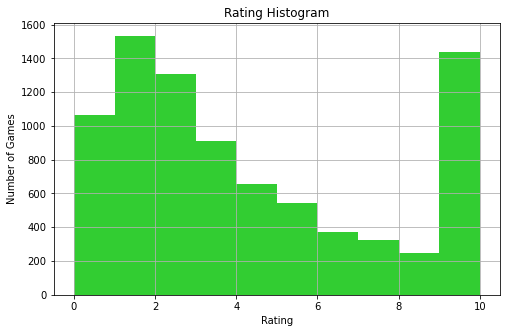

In [68]:
rat = plt.subplots(figsize=(8, 5))
rat = listed_data.ratings_std.hist(color='limegreen')
plt.xlabel('Rating')
plt.ylabel('Number of Games')
plt.title('Rating Histogram')
plt.show()

In [69]:
#to_1D(listed_data['ratings_std']).value_counts()
listed_data['ratings_std'].median()

3.0

In [70]:
round(listed_data['ratings_std'].mean(),2)

3.91

Średnia ocena gier na steam to 3.9 na 10

## Categories
#### Najpopularniejsze tagi gier 

In [71]:
styles = dict(cate_counts[:10])
rat = plt.subplots(figsize=(20, 5))
plt.bar(range(len(styles)), list(styles.values()), align='center', color='green')
plt.xticks(range(len(styles)), list(styles.keys()))
plt.ylabel('Amount of games')
plt.xlabel('Tags')
plt.title('Most popular tags')
plt.show()

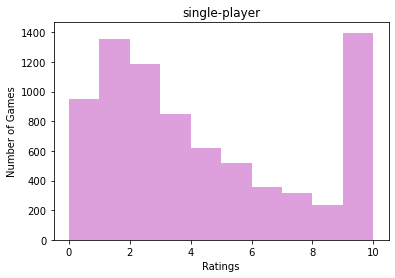

In [108]:
sin_pla_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'single-player'].astype(float)
sin_pla_freq.plot(kind='hist',color='plum')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('single-player')
plt.show()

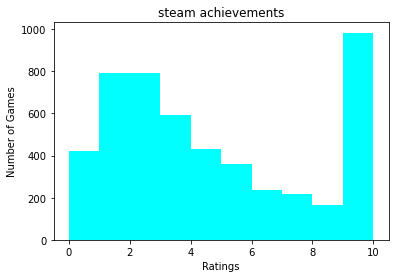

In [109]:
ste_ach_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'steam achievements'].astype(float)
ste_ach_freq.plot(kind='hist',color='cyan')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('steam achievements')
plt.show()

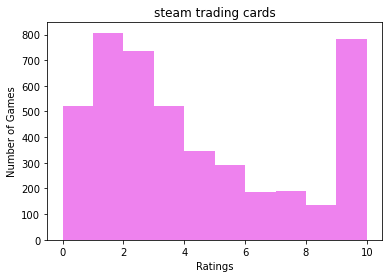

In [110]:
ste_tra_car_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'steam trading cards'].astype(float)
ste_tra_car_freq.plot(kind='hist',color='violet')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('steam trading cards')
plt.show()

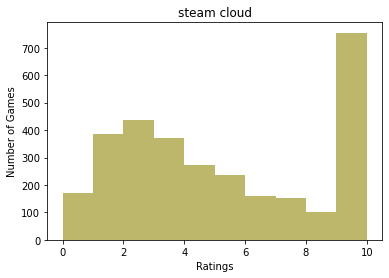

In [111]:
ste_clo_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'steam cloud'].astype(float)
ste_clo_freq.plot(kind='hist',color='darkkhaki')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('steam cloud')
plt.show()

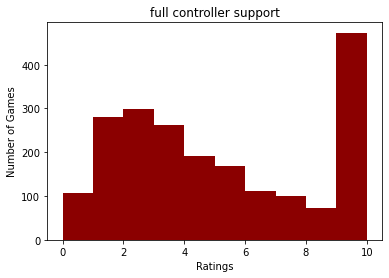

In [112]:
ful_con_sup_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'full controller support'].astype(float)
ful_con_sup_freq.plot(kind='hist',color='darkred')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('full controller support')
plt.show()

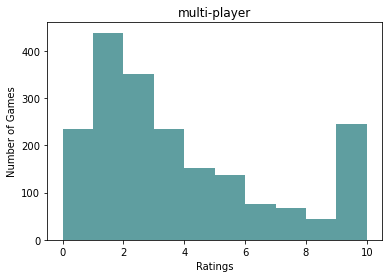

In [113]:
mul_pla_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'multi-player'].astype(float)
mul_pla_freq.plot(kind='hist',color='cadetblue')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('multi-player')
plt.show()

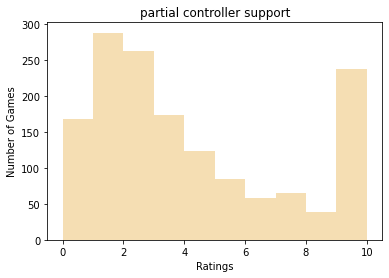

In [114]:
par_con_sup_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'partial controller support'].astype(float)
par_con_sup_freq.plot(kind='hist',color='wheat')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('partial controller support')
plt.show()

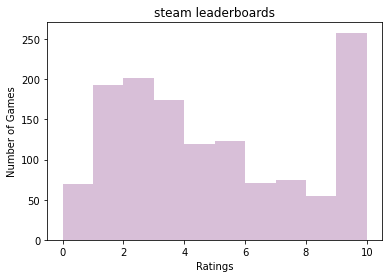

In [115]:
ste_lea_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'steam leaderboards'].astype(float)
ste_lea_freq.plot(kind='hist',color='thistle')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('steam leaderboards')
plt.show()

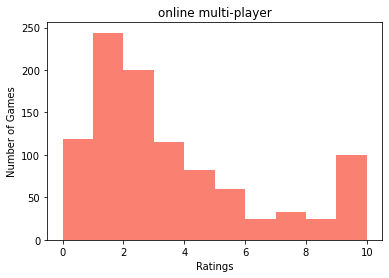

In [116]:
onl_mul_pla_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'online multi-player'].astype(float)
onl_mul_pla_freq.plot(kind='hist',color='salmon')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('online multi-player')
plt.show()

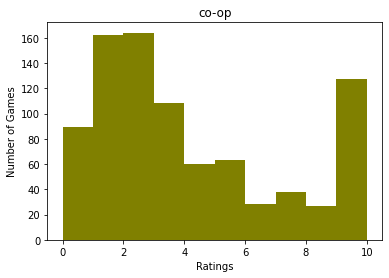

In [117]:
co_op_freq = test_data_cate['ratings_std'].loc[test_data_cate['categories'] == 'co-op'].astype(float)
co_op_freq.plot(kind='hist',color='olive')
plt.xlabel('Ratings')
plt.ylabel('Number of Games')
plt.title('co-op')
plt.show()

## Developer
#### Jak wysoko gry poszczególnych developerów są oceniane

In [119]:
dev_dicts = []
dev_names = []
devs = test_data_devs.developer.unique()
for c in devs:
    dev_dicts.append(dict(test_data_devs.ratings_std.loc[test_data_devs.developer == c].value_counts()))
    dev_names.append(c)

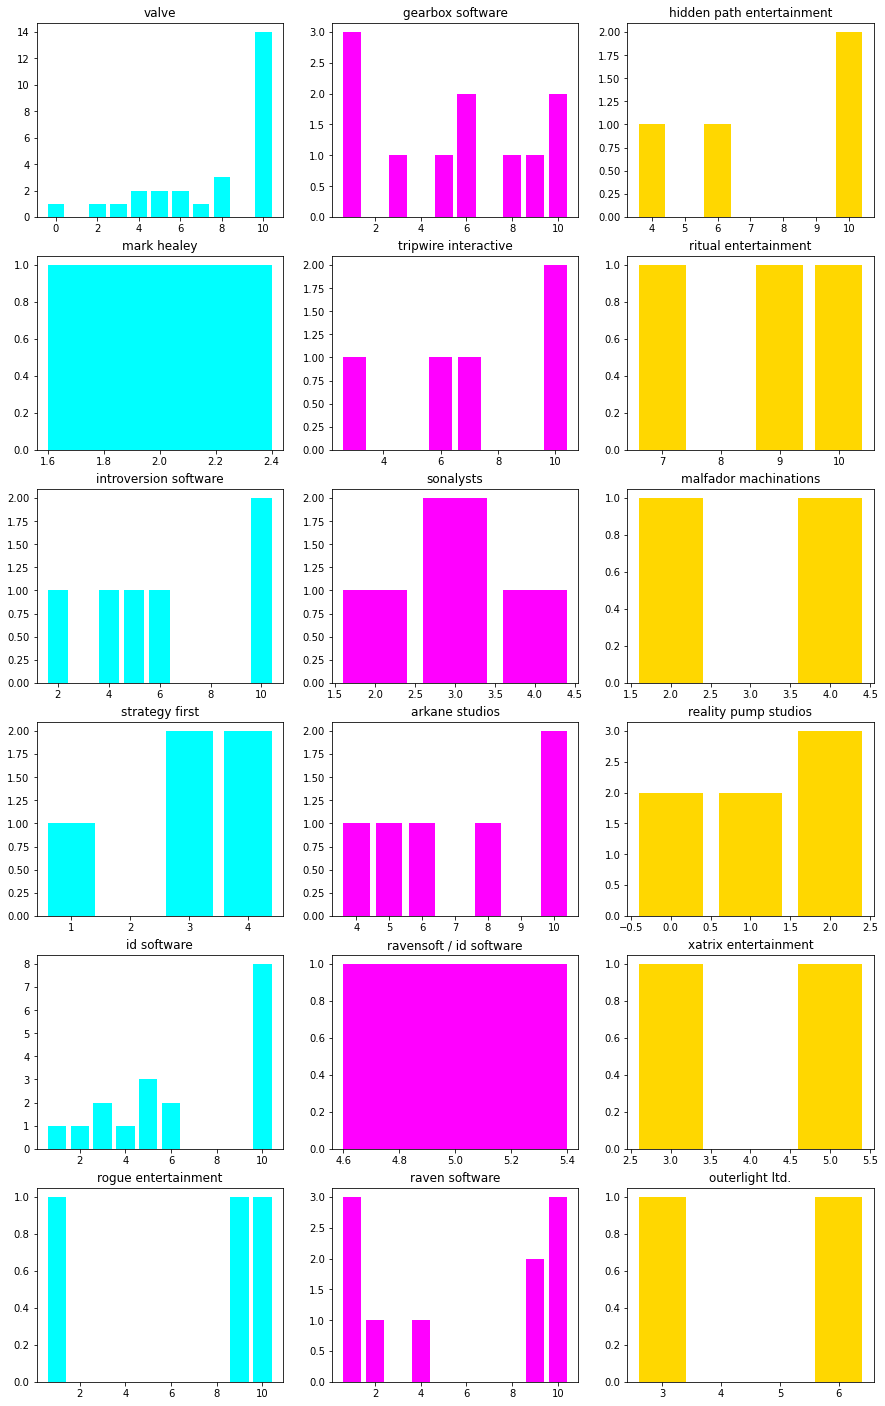

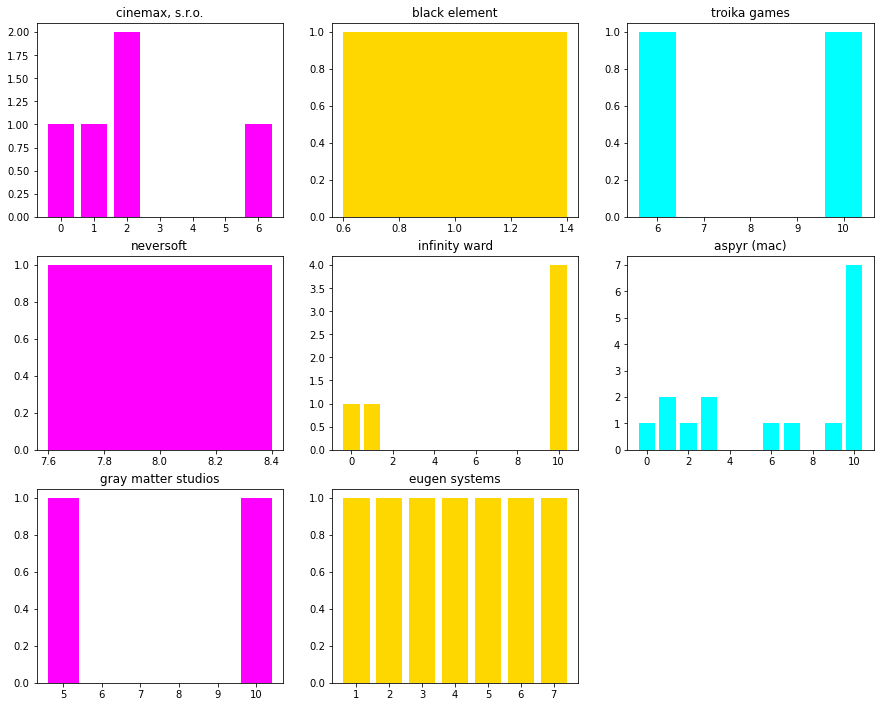

In [133]:
def findX(developers_dict):
    x = []
    for key,value in developers_dict.items():
        x.append(key)
    return x

def findY(developers_dict):
    y = []
    for key,value in developers_dict.items():
        y.append(value)
    return y

colors = ['cyan', 'magenta', 'gold']



plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(18):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(findX(dev_dicts[i]), findY(dev_dicts[i]), color=colors[i%3])
    ax.set_title(dev_names[i])
    plot_number = plot_number + 1

    
    
plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(19,len(devs_counts.unique())):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(findX(dev_dicts[i]), findY(dev_dicts[i]), color=colors[i%3])
    ax.set_title(dev_names[i])
    plot_number = plot_number + 1

In [134]:
test_data_devs.loc[test_data_devs['developer'] == 'neversoft']

appid  name release_year  developer     publisher       categories  \
66   2610  gun™         2006  neversoft  [activision]  [single-player]   

   achievements  ratings_std  pos_neg_ratings median_playtime        owners  \
66            0            8             8.51     above 200 h  50000-100000   

    price  
66   9.99

## Publisher
#### Jak wysoko gry poszczególnych developerów są oceniane

In [85]:
pub_dicts = []
pub_names = []
pub = test_data_publ.publisher.unique()
for c in pub:
    pub_dicts.append(dict(test_data_publ.ratings_std.loc[test_data_publ.publisher == c].value_counts()))
    pub_names.append(c)

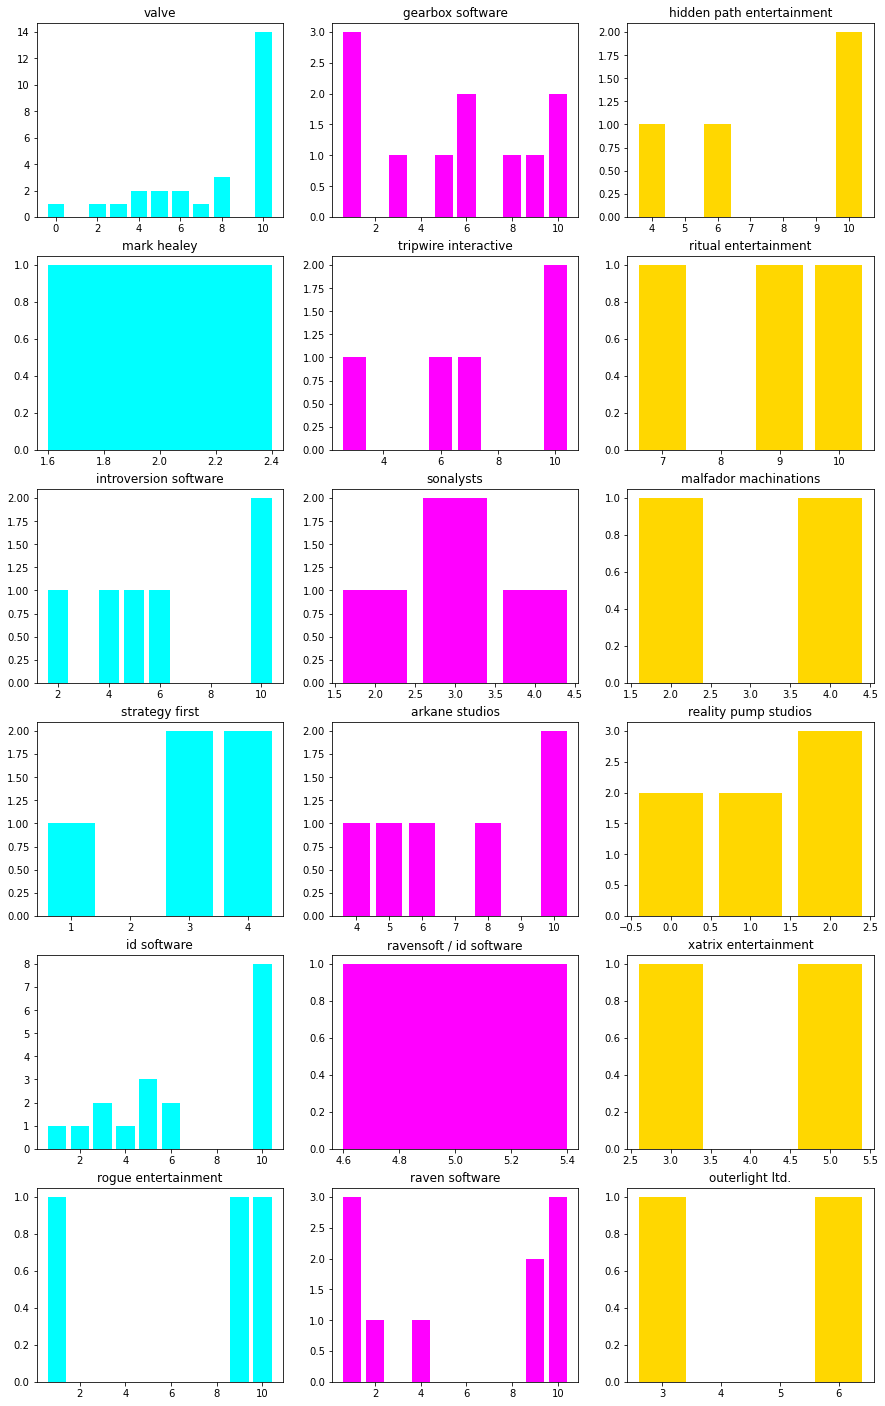

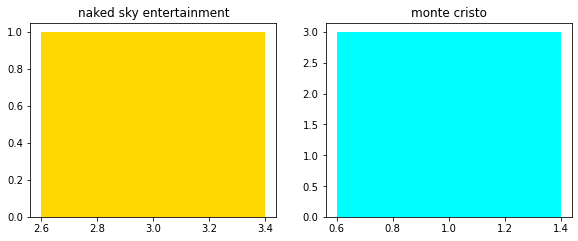

In [120]:
colors = ['cyan', 'magenta', 'gold']



plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(18):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(findX(dev_dicts[i]), findY(dev_dicts[i]), color=colors[i%3])
    ax.set_title(dev_names[i])
    plot_number = plot_number + 1

    
    
plt.figure(figsize=(15,25), facecolor='white')
plot_number = 1
for i in range(50,len(publ_counts.unique())):
    ax = plt.subplot(6, 3, plot_number)
    ax.bar(findX(dev_dicts[i]), findY(dev_dicts[i]), color=colors[i%3])
    ax.set_title(dev_names[i])
    plot_number = plot_number + 1

## Ilość gier od poszczególnych developerów

In [129]:
am_developers_to_counts = dict(devs_counts[:100])
devs_counts_plot = findX(am_developers_to_counts)
how_much_devs_counts_plot = findY(am_developers_to_counts)

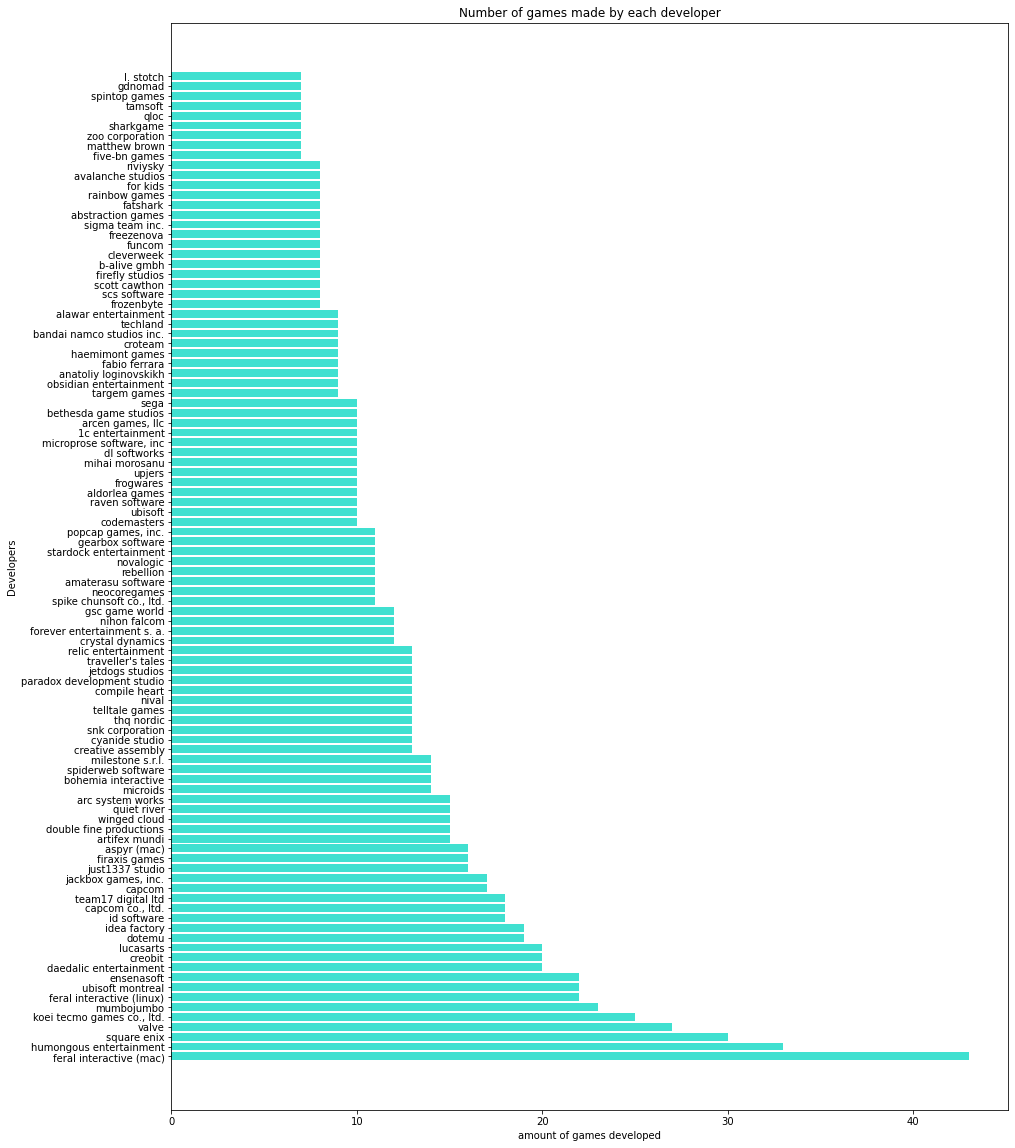

In [88]:
plt.figure(figsize=(15, 20))
plt.barh(devs_counts_plot,how_much_devs_counts_plot, color='turquoise')
plt.xlabel('amount of games developed')
plt.ylabel('Developers')
plt.title('Number of games made by each developer')
plt.show()

## Ilość gier od poszczególnych wydawców

In [130]:
am_publishers_to_counts = dict(publ_counts[:100])
publ_counts_plot = findX(am_publishers_to_counts)
how_much_publ_counts_plot = findY(am_publishers_to_counts)

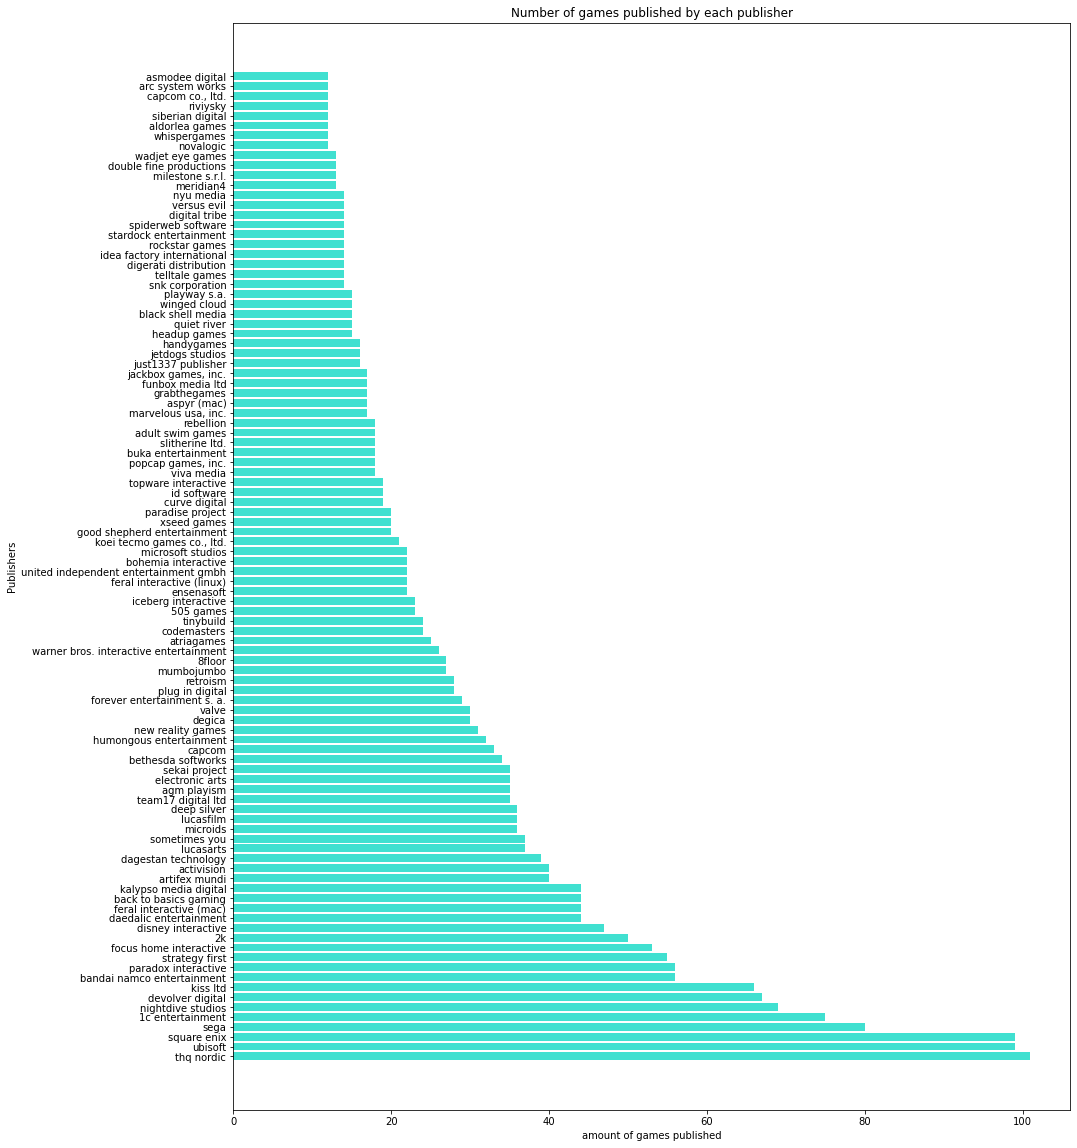

In [91]:
plt.figure(figsize=(15, 20))
plt.barh(publ_counts_plot,how_much_publ_counts_plot, color='turquoise')
plt.xlabel('amount of games published')
plt.ylabel('Publishers')
plt.title('Number of games published by each publisher')
plt.show()

In [92]:
test_data_devs.loc[test_data_devs['publisher'] == 'valve']

Empty DataFrame
Columns: [appid, name, release_year, developer, publisher, categories, achievements, ratings_std, pos_neg_ratings, median_playtime, owners, price]
Index: []

##  Top 10
###  Top 10 najlepszych developerów

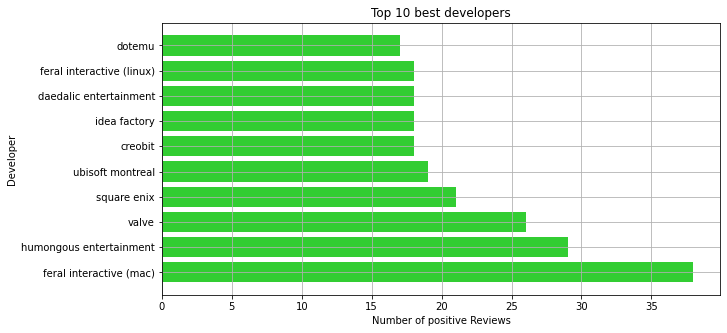

In [93]:
best_devs = dict(test_data_devs.developer.loc[test_data_devs.ratings_std.astype(float) > 1.0].value_counts())
devs_names = list(best_devs.keys())
brand_apperance_count = list(best_devs.values())
plt.figure(figsize=(10, 5))
plt.barh(devs_names[:10],brand_apperance_count[:10], color='limegreen')
plt.xlabel('Number of positive Reviews')
plt.ylabel('Developer')
plt.grid(True)
plt.title('Top 10 best developers')
plt.show()

###  Top 10 najlepszych wydawców

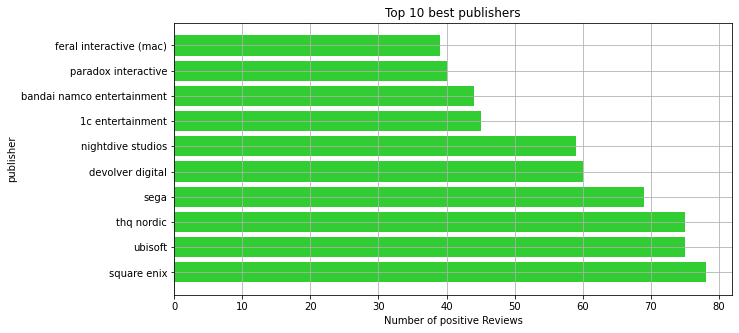

In [94]:
best_publ = dict(test_data_publ.publisher.loc[test_data_publ.ratings_std.astype(float) > 1.0].value_counts())
publ_names = list(best_publ.keys())
brand_apperance_count = list(best_publ.values())
plt.figure(figsize=(10, 5))
plt.barh(publ_names[:10],brand_apperance_count[:10], color='limegreen')
plt.xlabel('Number of positive Reviews')
plt.ylabel('publisher')
plt.grid(True)
plt.title('Top 10 best publishers')
plt.show()

###  Top 10 najgorszych developerów

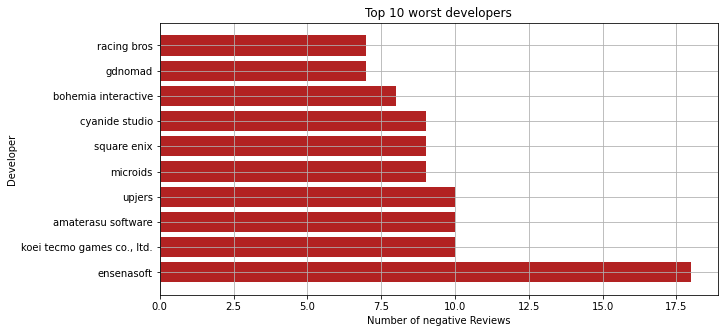

In [95]:
worst_devs = dict(test_data_devs.developer.loc[test_data_devs.ratings_std.astype(float) <= 1.0].value_counts())
devs_names = list(worst_devs.keys())
brand_apperance_count = list(worst_devs.values())
plt.figure(figsize=(10, 5))
plt.barh(devs_names[:10],brand_apperance_count[:10], color='firebrick')
plt.xlabel('Number of negative Reviews')
plt.ylabel('Developer')
plt.grid(True)
plt.title('Top 10 worst developers')
plt.show()

###  Top 10 najgorszych wydawców

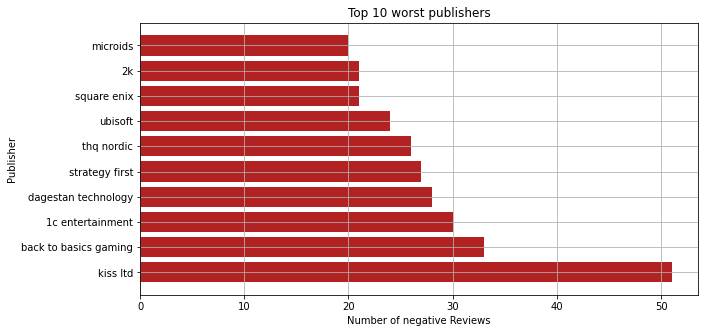

In [96]:
worst_publ = dict(test_data_publ.publisher.loc[test_data_publ.ratings_std.astype(float) <= 1.0].value_counts())
publ_names = list(worst_publ.keys())
brand_apperance_count = list(worst_publ.values())
plt.figure(figsize=(10, 5))
plt.barh(publ_names[:10],brand_apperance_count[:10], color='firebrick')
plt.xlabel('Number of negative Reviews')
plt.ylabel('Publisher')
plt.grid(True)
plt.title('Top 10 worst publishers')
plt.show()

## Procentowa wartość dobrych i złych developerów

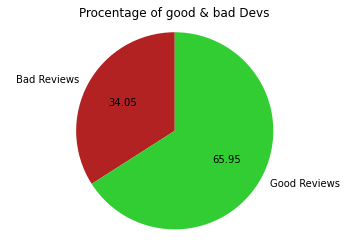

In [97]:
x = [len(test_data_devs.developer.loc[test_data_devs.ratings_std.astype(float) <= 1.0].value_counts()),len(test_data_devs.developer.loc[test_data_devs.ratings_std.astype(float) > 1.0].value_counts())]
plt.pie(x, labels=['Bad Reviews', 'Good Reviews'], autopct='%1.2f', startangle=90, colors=['firebrick','limegreen'])
plt.axis('equal')
plt.title('Procentage of good & bad Devs')
plt.show()

## Procentowa wartość dobrych i złych wydawców

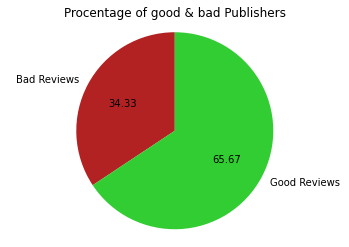

In [98]:
x = [len(test_data_publ.publisher.loc[test_data_publ.ratings_std.astype(float) <= 1.0].value_counts()),len(test_data_publ.publisher.loc[test_data_publ.ratings_std.astype(float) > 1.0].value_counts())]
plt.pie(x, labels=['Bad Reviews', 'Good Reviews'], autopct='%1.2f', startangle=90, colors=['firebrick','limegreen'])
plt.axis('equal')
plt.title('Procentage of good & bad Publishers')
plt.show()

## Zależność oceny od 10 najpopularniejszych tagów 

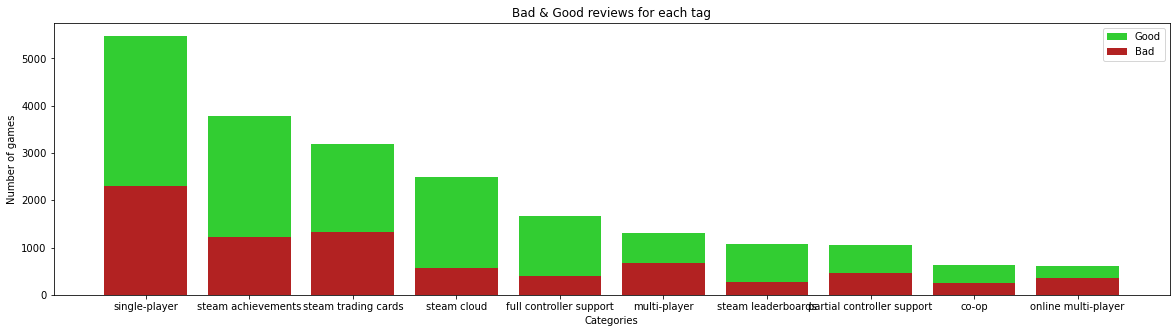

In [141]:
#categories = dict(cate_counts[:10])
rat = plt.subplots(figsize=(20, 5))
ax = plt.subplot(111)
good = ax.bar(findX(test_data_cate.categories.loc[test_data_cate.ratings_std.astype(float) > 1.0].value_counts()[:10]),findY(test_data_cate.categories.loc[test_data_cate.ratings_std.astype(float) > 1.0].value_counts()[:10]), color="limegreen")
bad = ax.bar(findX(test_data_cate.categories.loc[test_data_cate.ratings_std.astype(float) <= 1.0].value_counts()[:10]),findY(test_data_cate.categories.loc[test_data_cate.ratings_std.astype(float) <= 1.0].value_counts()[:10]),color="firebrick")
ax.legend((good, bad), ('Good', 'Bad'))
plt.xlabel('Categories')
plt.ylabel('Number of games')
plt.title('Bad & Good reviews for each tag')
plt.show()

## Ilu developerów jest zainteresowanych tworzeniem gier z poszczególnymi tagami

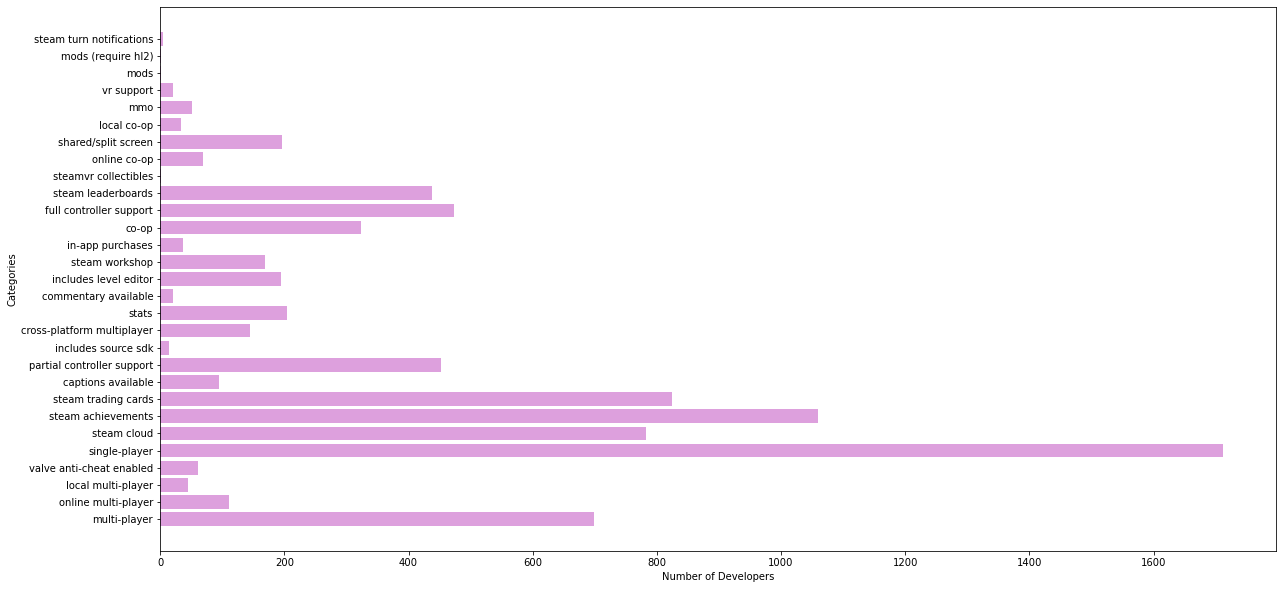

In [142]:
Categories1 = {style: len(test_data_devs.developer.loc[test_data_cate.categories == style].unique()) for style in test_data_cate.categories.unique()}

rat = plt.subplots(figsize=(20, 10))
plt.barh(findX(Categories1),findY(Categories1),color='plum')
plt.xlabel('Number of Developers')
plt.ylabel('Categories')
plt.show()

# Uczenie Maszynowe
### Przykład zastosowania PyTorch

In [102]:
#UNLIST EVERYTHING
rozbite1 = test_data_devs
rozbite1 = rozbite1.explode('publisher').reset_index(drop=True)
rozbite2 = rozbite1
rozbite2 = rozbite2.explode('categories').reset_index(drop=True)
#rozbite2 = rozbite1
#rozbite2 = rozbite2.explode('publisher').reset_index(drop=True)

#publ_counts = rozbite1["publisher"].value_counts()

#publ_counts
rozbite2.head()

appid                   name release_year developer publisher  \
0     10         counter-strike         2000     valve     valve   
1     10         counter-strike         2000     valve     valve   
2     10         counter-strike         2000     valve     valve   
3     10         counter-strike         2000     valve     valve   
4     20  team fortress classic         1999     valve     valve   

                 categories achievements  ratings_std  pos_neg_ratings  \
0              multi-player            0           10            37.30   
1       online multi-player            0           10            37.30   
2        local multi-player            0           10            37.30   
3  valve anti-cheat enabled            0           10            37.30   
4              multi-player            0            5             5.24   

  median_playtime             owners  price  
0     above 200 h  10000000-20000000   7.19  
1     above 200 h  10000000-20000000   7.19  
2     above 200 h  10000000-20000000   7.19  
3     above 200 h  10000000-20000000   7.19  
4     21 to 100 h   5000000-10000000   3.99

In [103]:
rozbite2.shape

(42081, 12)

In [166]:
#rozbite2['ratings_std'] = rozbite2['ratings_std'].astype(float)
test_data_devs['ratings_std'] = test_data_devs['ratings_std'].astype(float)
listed_data['ratings_std'] = listed_data['ratings_std'].astype(float)

#Publisher = pd.get_dummies(test_data_publ['publisher'], prefix='publisher', drop_first=True)
#Developer = pd.get_dummies(test_data_devs['developer'], prefix='developer',drop_first=True)

Categories = pd.get_dummies(test_data_devs['developer'], prefix='developer',drop_first=True)
Price = pd.get_dummies(test_data_devs['achievements'], prefix='achievements',drop_first=True)

#Categories = pd.get_dummies(listed_data['owners'], prefix='owners',drop_first=True)
#Price = pd.get_dummies(listed_data['price'], prefix='price',drop_first=True)

#datadf = pd.concat([Publisher, Developer, Categories], axis=1)
datadf = pd.concat([Price, Categories], axis=1)
print(datadf.shape)
X = np.array(datadf, dtype=np.float32) 
y = np.array(test_data_devs[['ratings_std']], dtype=np.float32)
m = nn.Linear(datadf.shape[1], 1)

loss = nn.MSELoss()

opt = torch.optim.SGD(m.parameters(), lr=0.5)
for dataepoch in range(2000):
    datain = torch.from_numpy(X)
    datatrgs = torch.from_numpy(y)
    
    dataout = m(datain)
    cost = loss(dataout, datatrgs)
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    if (dataepoch+1) % 100 == 0:
        print ('Epoch for steamdb.csv {}/{}\nLoss: {:.4f}'.format(dataepoch+1, 2000, cost.item()))
        #print ('Epoch for steamdb.csv [{}]\nLoss: {:.4f}'.format(dataepoch+1, 1000))

y_predict = m(torch.from_numpy(X)).data.numpy()

print(y_predict[0:5])
print(y[0:5])

metrics.mean_squared_error(y, y_predict)

(9277, 5612)
Epoch for steamdb.csv 100/2000
Loss: 10.7084
Epoch for steamdb.csv 200/2000
Loss: 10.2993
Epoch for steamdb.csv 300/2000
Loss: 9.9443
Epoch for steamdb.csv 400/2000
Loss: 9.6286
Epoch for steamdb.csv 500/2000
Loss: 9.3433
Epoch for steamdb.csv 600/2000
Loss: 9.0822
Epoch for steamdb.csv 700/2000
Loss: 8.8411
Epoch for steamdb.csv 800/2000
Loss: 8.6171
Epoch for steamdb.csv 900/2000
Loss: 8.4076
Epoch for steamdb.csv 1000/2000
Loss: 8.2110
Epoch for steamdb.csv 1100/2000
Loss: 8.0258
Epoch for steamdb.csv 1200/2000
Loss: 7.8508
Epoch for steamdb.csv 1300/2000
Loss: 7.6849
Epoch for steamdb.csv 1400/2000
Loss: 7.5275
Epoch for steamdb.csv 1500/2000
Loss: 7.3776
Epoch for steamdb.csv 1600/2000
Loss: 7.2347
Epoch for steamdb.csv 1700/2000
Loss: 7.0983
Epoch for steamdb.csv 1800/2000
Loss: 6.9679
Epoch for steamdb.csv 1900/2000
Loss: 6.8431
Epoch for steamdb.csv 2000/2000
Loss: 6.7234
[[7.1511116]
 [7.1511116]
 [7.1511116]
 [7.1511116]
 [4.681531 ]]
[[10.]
 [ 5.]
 [ 8.]
 [ 4.]


6.7222266

In [105]:
datadf.head()

price_0.32  price_0.49  price_0.59  price_0.72  price_0.75  price_0.78  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   price_0.79  price_0.9  price_0.99  price_1.0  ...  categories_stats  \
0           0          0           0          0  ...                 0   
1           0          0           0          0  ...                 0   
2           0          0           0          0  ...                 0   
3           0          0           0          0  ...                 0   
4           0          0           0          0  ...                 0   

   categories_steam achievements  categories_steam cloud  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   

   categories_steam leaderboards  categories_steam trading cards  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   categories_steam turn notifications  categories_steam workshop  \
0                                    0                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   

   categories_steamvr collectibles  categories_valve anti-cheat enabled  \
0                                0                                    0   
1                                0                                    0   
2                                0                                    0   
3                                0                                    1   
4                                0                                    0   

   categories_vr support  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 170 columns]

## AdaBoost, Metoda Elbow, Klasteryzacja k-means

In [170]:
#dummies = pd.get_dummies(test_data_devs[["developer"]] )
#dummies += pd.get_dummies(test_data_publ[["publisher"]] )
#dummies += pd.get_dummies(test_data_cate[["categories"]] )
dummies= pd.get_dummies(rozbite2[["developer","publisher","categories","price"]])
dummies2 = pd.get_dummies(rozbite2[["developer","publisher","price"]])
dummies3 = pd.get_dummies(test_data_devs[["developer","price","release_year"]])

reviews = test_data_devs[["ratings_std"]]
data3 = pd.concat((dummies3, reviews), axis=1)
#dummies2.head()
dummies3.head()

price  developer_"ellie"  developer_.dat  developer_07th expansion  \
0   7.19                  0               0                         0   
1   3.99                  0               0                         0   
2   3.99                  0               0                         0   
3   3.99                  0               0                         0   
4   3.99                  0               0                         0   

   developer_100 stones interactive  developer_10th art studio  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   

   developer_10tons ltd  developer_11 bit studios  developer_13-lab  \
0                     0                         0                 0   
1                     0                         0                 0   
2                     0                         0                 0   
3                     0                         0                 0   
4                     0                         0                 0   

   developer_14° east  ...  release_year_2010  release_year_2011  \
0                   0  ...                  0                  0   
1                   0  ...                  0                  0   
2                   0  ...                  0                  0   
3                   0  ...                  0                  0   
4                   0  ...                  0                  0   

   release_year_2012  release_year_2013  release_year_2014  release_year_2015  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   release_year_2016  release_year_2017  release_year_2018  release_year_2019  
0                  0                  0                  0                  0  
1                  0                  0                  0                  0  
2                  0                  0                  0                  0  
3                  0                  0                  0                  0  
4                  0                  0                  0                  0  

[5 rows x 5634 columns]

In [107]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

D:\Programy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


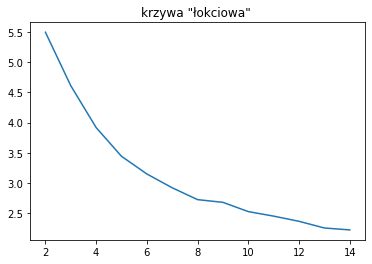

In [167]:
res=list()
#print("1")
n_cluster = range(2,15)
#print("2")
for n in n_cluster: 
    #print("3")
    kmeans = KMeans(n_clusters = n)
    #print("4")
    kmeans.fit(data3)
    #print("5")
    res.append(np.average(np.min(cdist(data3, kmeans.cluster_centers_, 'euclidean'), axis=1)))
    #print("6")

plt.plot(n_cluster, res)
#print("7")
plt.title('krzywa \"łokciowa\" ')
#print("8")

kmeans_model=KMeans(n_clusters=7,init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data3);
#print("9")
results = kmeans_model.predict(data3)
#print("10")
centroids = kmeans_model.cluster_centers_
#print("11")
kmeans_n = pd.DataFrame(data = results)
#print("12")
data["Score"] = kmeans_n
#print("13")
res= kmeans_model.__dict__
#print("14")

res2 = pd.DataFrame.from_dict(res, orient='index')

In [172]:
data4 = data3
#print("1")
klaster_H = linkage(data4,'ward')
#print("2")
klaster_2 = fcluster(klaster_H, 5, criterion='maxclust')
#print("3")
klaster_Hierarchical = pd.DataFrame(klaster_2)
#print("4")
data4.to_csv("drzewo.csv")

In [175]:
X = data3.drop(["ratings_std"], axis=1)
#print("1")
data3["ratings_std"] = pd.to_numeric(data3["ratings_std"], errors='coerce')
#print("2")
y = data3["ratings_std"].astype(int)
#print("3")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
#print("4")
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1)
#print("5")
X_train = X_train.fillna(X_train.mean())
#print("6")
y_train = y_train.fillna(y_train.mean())
#print("7")
X_test = X_test.fillna(X_test.mean())
#print("8")
y_test = y_test.fillna(y_test.mean())
#print("9")
model = abc.fit(X_train, y_train)
#print("10")
y_pred = model.predict(X_test)
#print("11")
print("Dokładność:",metrics.accuracy_score(y_test, y_pred))

Dokładność: 0.21153327943950417


In [174]:
X = data3.drop(["ratings_std"], axis=1)
#print("1")
data3["ratings_std"] = pd.to_numeric(data3["ratings_std"], errors='coerce')
#print("2")
#print(data3["ratings_std"].dtype)
#print("3")
y = data3["ratings_std"].astype(int)
#print("4")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
#print("5")
abc = AdaBoostClassifier(n_estimators=1000, learning_rate=1)
#print("6")
X_train = X_train.fillna(X_train.mean())
#print("7")
y_train = y_train.fillna(y_train.mean())
#print("8")
X_test = X_test.fillna(X_test.mean())
#print("9")
y_test = y_test.fillna(y_test.mean())
#print("10")
model = abc.fit(X_train, y_train)
#print("11")
y_pred = model.predict(X_test)
#print("12")
print("Dokładność:",metrics.accuracy_score(y_test, y_pred))

Dokładność: 0.2165948275862069
